In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [361]:
df_true = pd.read_csv("./db/True.csv",sep=',')
df_false = pd.read_csv("./db/Fake.csv",sep=',')

In [362]:
df_true['real'] = 1
df_false['real'] = 0

In [363]:
df = pd.concat([df_true,df_false])
df = df.drop(['date'], axis=1) # may be questionable, check later.

In [364]:
df.head()

,title,text,subject,real
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


In [365]:
def pre_process_text_fields(df, cols):
    df[cols] = df[cols].apply(lambda x: x.str.lower())
    return df

In [366]:
df = pre_process_text_fields(df, ['title', 'text'])

In [367]:
df.head()

,title,text,subject,real
0,"as u.s. budget fight looms, republicans flip t...",washington (reuters) - the head of a conservat...,politicsNews,1
1,u.s. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsNews,1
2,senior u.s. republican senator: 'let mr. muell...,washington (reuters) - the special counsel inv...,politicsNews,1
3,fbi russia probe helped by australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsNews,1
4,trump wants postal service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsNews,1


In [368]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['text_len'] = df['text'].apply(lambda x: len(x))

In [369]:
df["origin"] = df["text"].apply(lambda x: x.split("-")[0])
df["text"] = df["text"].apply(lambda x: 
    x if len(x.split("-")) <= 1
    else x.split("-")[1]
)

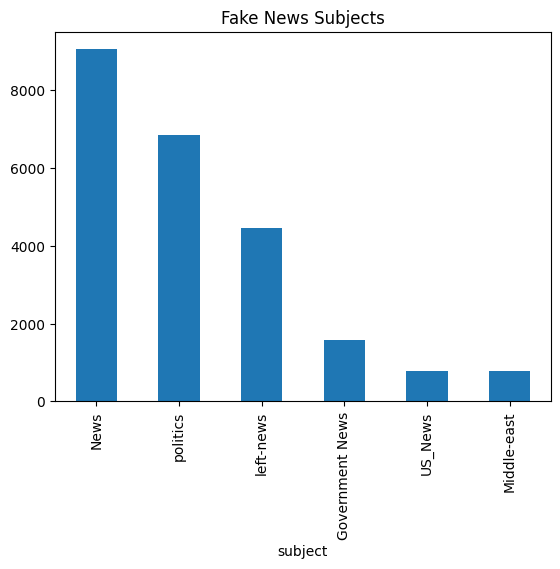

In [370]:
fake = df["real"] == 0
df[fake]["subject"].value_counts().plot(kind='bar')
plt.title("Fake News Subjects")
plt.show()

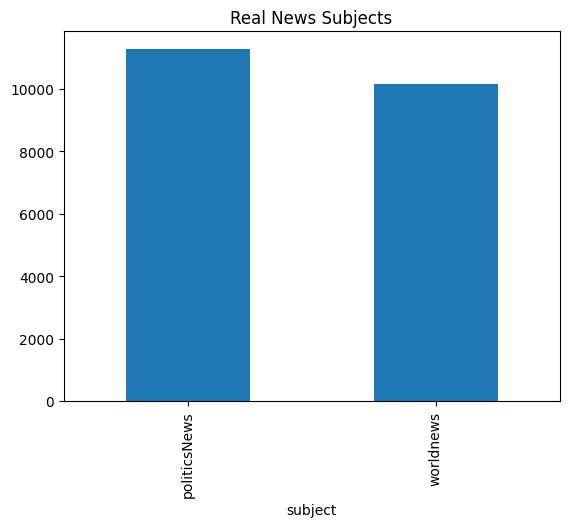

In [371]:
df[~fake]["subject"].value_counts().plot(kind='bar')
plt.title("Real News Subjects")
plt.show()

<Axes: ylabel='Frequency'>

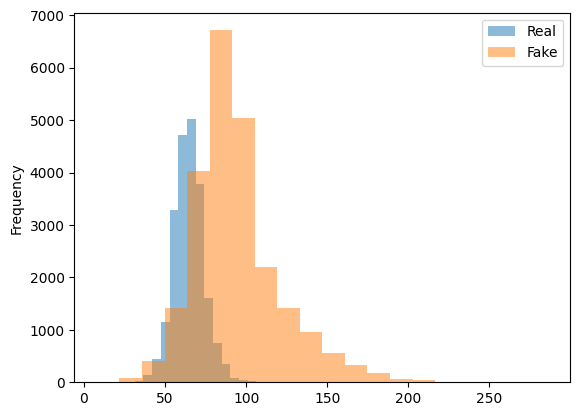

In [372]:
df[~fake]['title_len'].plot(kind='hist', bins=20, alpha=0.5, label='Real', legend=True)
df[fake]['title_len'].plot(kind='hist', bins=20, alpha=0.5, label='Fake', legend=True)

<Axes: ylabel='Frequency'>

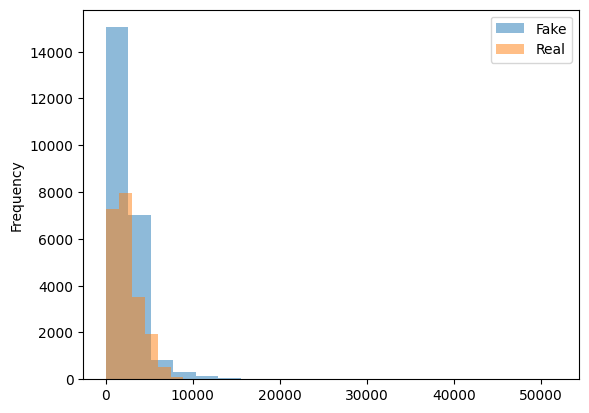

In [373]:
df[fake]['text_len'].plot(kind='hist', bins=20, alpha=0.5, label='Fake', legend=True)
df[~fake]['text_len'].plot(kind='hist', bins=20, alpha=0.5, label='Real', legend=True)

In [374]:
len(df[fake]), len(df[~fake])

(23481, 21417)

In [375]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [376]:
def new_pipeline():
    return Pipeline([
        ('Vectorizer', CountVectorizer(binary=True)),  
        ('Classifier', LogisticRegression()),  
    ])

In [377]:
def train_test_split(df_true, df_false):
    X = pd.concat([df_true['text'], df_false['text']])
    y = pd.concat([pd.Series(np.ones(len(df_true))), pd.Series(np.zeros(len(df_false)))])

    return train_test_split(X, y, test_size=0.2, random_state=42)

In [378]:
# define preprocessing pipeline
pipe_text = new_pipeline()

In [379]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [380]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df['real'], test_size=0.2, random_state=42)

pipe_text.fit(X_train, y_train)
pred_text = pipe_text.predict(X_test)

In [381]:
print(classification_report(pred_text, y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4796
           1       0.93      0.97      0.95      4184

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [382]:
words = pipe_text['Vectorizer'].get_feature_names_out()
coefs = pipe_text['Classifier'].coef_
classes = pipe_text['Classifier'].classes_
print(words.shape)
sorted_coef_indexes = coefs.argsort(axis=1)

(59523,)


In [383]:
print(classes[0])
top5words = words[sorted_coef_indexes[0,:10]]
print(top5words)
top5coefs = coefs[0,sorted_coef_indexes[0,:10]]
print(top5coefs)

0
['via' 'elect' 'rep' 'gop' 'us' 'mr' 'read' 'sen' 'https' 'wing']
[-3.64908823 -3.3124771  -3.21743969 -2.77557828 -2.49077262 -2.44329297
 -2.43128982 -2.3590832  -2.23905882 -2.16083212]


In [384]:
print(classes[1])
last5words = words[sorted_coef_indexes[0,-10:]]
print(last5words)
last5coefs = coefs[0,sorted_coef_indexes[0,-10:]]
print(last5coefs)

1
['london' 'monday' 'saad' 'saudi' 'wednesday' 'president' 'reuters'
 'donald' 'est' 'edt']
[2.23657812 2.24536807 2.31098207 2.36332918 2.49612189 2.79392524
 2.97957658 3.14780491 3.33673445 4.30818666]
